<a href="https://colab.research.google.com/github/jfjoung/AI_For_Chemistry/blob/main/Week_3_Graph_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 🎯 **학습 목표:**  
- **그래프 뉴럴 네트워크(GNN)의 기본 개념**과 **화학 데이터에서의 활용**을 이해한다.  
- **SMILES 및 분자 구조 데이터를 그래프 표현으로 변환하는 방법**을 익힌다.  
- **PyTorch Geometric을 활용하여 그래프 기반 딥러닝 모델을 설계하고 학습한다.**  
- **GNN 모델의 주요 구성 요소**(예: 노드 특징, 엣지 연결 정보, 메시지 전달)를 학습한다.  
- **GCN(Graph Convolutional Network) 및 GAT(Graph Attention Network)와 같은 주요 GNN 아키텍처를 실습한다.**  
- **기본 MLP 모델과 GNN 모델의 성능을 비교하여 그래프 기반 학습의 장점을 분석한다.**  
- **그래프 뉴럴 네트워크를 활용하여 화학적 속성을 예측하는 모델을 직접 구현하고 평가한다.**  


### 런타임 유형 변경

1. Colab 상단 메뉴에서 **`런타임` → `런타임 유형 변경`**을 클릭합니다.  
2. **하드웨어 가속기**를 **GPU**로 변경한 후 **저장**을 누릅니다.


# 0. 관련 패키지

### Pytorch Geometric (PyG)
PyG는 PyTorch 기반의 라이브러리로, 구조화된 데이터를 활용한 다양한 응용 분야에서 **그래프 뉴럴 네트워크(GNNs)**를 쉽게 작성하고 학습할 수 있도록 지원합니다.  
추가적인 세부 사항은 [공식 문서](https://pytorch-geometric.readthedocs.io/en/latest/)를 참고하세요.


In [1]:
# 모든 라이브러리 설치
# CoLab에는 이미 PyTorch가 사전 설치되어 있습니다.

! pip install pytorch-lightning rdkit ogb deepchem

# PyG(Pytorch Geometric) 설치
import torch
VERSION = torch.__version__  # 현재 PyTorch 버전 확인
! pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-{VERSION}.html
! pip install torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [ ]:
import torch
print("GPU 사용 가능 여부:", torch.cuda.is_available())
print("사용 중인 GPU 이름:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


실험의 재현성을 보장하기 위해 난수 시드를 설정합니다.


In [ ]:
import random
import numpy as np
import torch

# 실험의 재현성을 보장하기 위해 난수 시드를 설정합니다.
torch.manual_seed(0)  # PyTorch에서 난수 시드 설정
torch.cuda.manual_seed(0)  # CUDA 연산 시 동일한 결과를 보장하기 위한 시드 설정
np.random.seed(0)  # NumPy의 난수 시드 설정
random.seed(0)  # Python 기본 random 모듈의 난수 시드 설정


---

딥러닝 알고리즘의 강점 중 하나는 **원 데이터(raw data)에서 자동으로 특징을 추출할 수 있다는 점**입니다.  
그러나 지금까지 우리는 기본 모델에서 사용했던 것과 동일한 특성 변환(featurization) 방법을 사용해 왔습니다.

> 그렇다면, **우리의 모델이 직접 분자를 입력으로 받을 수 있을까요?**

# 1. 귀납적 편향 (Inductive Biases)

**귀납적 편향(Inductive Biases)**이란, 모델이 데이터를 해석할 때 가정을 적용하여 중요한 패턴을 학습하도록 돕는 것을 의미합니다.  
이러한 가정은 모델의 **아키텍처(architecture)**에 내재되어 있습니다.

예를 들어, 인간이 이미지를 볼 때와 책을 읽을 때, 또는 분자를 분석할 때의 사고 방식은 서로 다릅니다.  
**이처럼 다양한 데이터 유형을 처리하려면 각 데이터에 적절한 해석 방법과 가정을 적용해야 합니다.**

모델을 설계할 때, 우리는 이러한 **귀납적 편향**을 모델의 구조에 반영하여 데이터 해석 방식을 학습할 수 있도록 합니다.

### **분자를 그래프로 표현하는 방법**
분자를 자연스럽게 표현하는 방식 중 하나는 **그래프(Graph)**입니다.  
그래프는 **노드(Node, 원자)**와 **엣지(Edge, 결합)**의 집합으로 이루어져 있습니다.

<div align="center">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/Chloroquine-2D-molecular-graph.png" width="500"/>
</div>

결국, 우리가 데이터에서 가정하는 것은 다음과 같습니다.

> 분자는 **원자(노드)와 결합(엣지)으로 이루어져 있으며, 각 원자는 주로 가까운 이웃 원자에 의해 영향을 받는다.**  
> 분자의 물리·화학적 성질은 **오직 분자 그래프의 구조에 의해 결정된다.**

이러한 가정을 모델에게 전달하면, **분자의 용해도(solubility)나 기타 물성을 예측하는 방법을 모델이 직접 데이터로부터 학습할 수 있습니다!** 🚀


# 2. 화학에서의 그래프 뉴럴 네트워크(Graph Neural Network, GNN)


## 2.1 그래프 표현 (Graph Representation)

[그래프 이론](https://en.wikipedia.org/wiki/Graph_theory)에서 **그래프** $G = (V, E)$는 **노드(Vertices)** 집합 $V$과 **엣지(Edges)** 집합 $E$로 정의됩니다.  
보다 구체적으로:

- $ V = \{ v_1, \: ..., \: v_n \} $ : **노드(Node) 집합**
- $ E \subseteq \{ (i,j) \: | \: i,j \in V, \: i \neq j \} $ : **노드 간의 연결(엣지, Edge) 집합**

그래프의 엣지(Edge)에 **방향(Direction)**이 있으면 이를 **유향 그래프(Directed Graph)**, 방향이 없으면 **무향 그래프(Undirected Graph)**라고 합니다.

<center width="100%" style="padding:10px">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/graphs.png" width="250px">
</center>

---

### **그래프의 특징 정보 (Attributes & Features)**

일반적으로 그래프에는 노드, 엣지, 그래프 자체에 대한 특징(feature) 정보가 포함될 수 있습니다.

- **노드 특징(Node Features)**  
  $ \mathbf{X} = [..., \: x_i, \: ...]^T \in \mathbb{R}^{|V| \times m} $  
  - 여기서 $ x_i \in \mathbb{R}^m $ 은 노드 $i$의 특징 벡터  
  - $ m $: 하나의 노드가 가지는 특징(feature)의 개수 (예: 원자 종류, 전하, 혼성화 상태 등)

- **엣지 특징(Edge Features)**  
  $ \mathbf{L} = [..., \: l_{i,j}, \: ...]^T \in \mathbb{R}^{|E| \times r} $  
  - 여기서 $ l_{i,j} \in \mathbb{R}^r $ 은 노드 $i$와 $j$ 사이의 엣지 특징 벡터  
  - $ r $: 하나의 엣지가 가지는 특징(feature)의 개수 (예: 결합 차수, 결합 길이 등)

- **그래프 특징(Graph Features)**  
  $ \mathbf{G} = (..., \: g_i, \: ...) \in \mathbb{R}^s $  
  - 여기서 $ g_i $ 는 그래프 전체에 대한 특징 (또는 예측 목표)  
  - $ s $: 그래프 전체가 가지는 특징(feature)의 개수 (예: 분자량, 용해도 등)

---

예를 들어, 다음과 같은 **무향 그래프(Undirected Graph)**를 살펴보겠습니다.

<center width="100%" style="padding:10px">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/graph_example.svg" width="250px">
</center>

이 그래프는 **4개의 노드**와 **4개의 엣지**를 가집니다.

- **노드(Node) 집합**: $ V = \{1,2,3,4\} $  
- **엣지(Edge) 집합**: $ E = \{(1,2), (2,3), (2,4), (3,4)\} $  
  (간단히 표현하기 위해 **대칭된 엣지**(예: $(2,1)$)는 생략)

각 노드는 다음과 같은 특징 벡터를 가집니다.

$$
\mathbf{X} = \begin{bmatrix}
    0 & 1 & 2\\
    1 & 0 & 1\\
    1 & 1 & 0\\
    3 & 1 & 4
\end{bmatrix}
$$

여기서 $ m = 3 $, 즉 각 노드는 3개의 특징(feature)을 가지고 있습니다.

---

### **인접 행렬 (Adjacency Matrix) $ A $**

그래프의 **인접 행렬** $ A $는 노드 간의 연결 여부를 나타내는 **정방 행렬(Square Matrix)**입니다.  
가장 단순한 경우, 두 노드 $ i, j $가 연결되어 있으면 $ A_{ij} = 1 $, 그렇지 않으면 $ 0 $이 됩니다.

**무향 그래프(Undirected Graph)**에서는 **인접 행렬 $ A $가 대칭 행렬(Symmetric Matrix)이며, $ A_{ij} = A_{ji} $가 성립합니다.**

위의 그래프 예제에서 인접 행렬은 다음과 같습니다.

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$


### 분자 그래프 (Molecular Graph)

[분자 그래프](https://en.wikipedia.org/wiki/Molecular_graph)는 **화합물의 원자**를 노드로, **화학 결합**을 엣지로 나타내는 **레이블이 지정된 그래프(labeled graph)**입니다.  
또한, 분자 그래프에는 다음과 같은 특징 정보가 포함될 수 있습니다.

- **노드 특징 (Atom Features)**: 원자의 종류, 전하, 혼성화 상태 등  
- **엣지 특징 (Bond Features)**: 결합 차수, 결합 극성, 결합 길이 등  
- **그래프 레이블 (Graph Labels)**: 분자의 용해도, 분자량, 독성 등 분자의 물리·화학적 성질  

다음은 **무향 그래프(Undirected Graph)**를 사용하여 **분자 그래프를 구성하는 예제**입니다.  
이 예제에서는 **수소 원자(Hydrogen)를 노드로 포함하지 않습니다.**


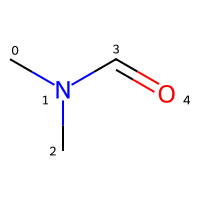

In [3]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# RDKit의 IPython 환경 설정
IPythonConsole.ipython_useSVG = True  # SVG 형식으로 분자 구조 표시
IPythonConsole.drawOptions.addAtomIndices = True  # 원자 인덱스 표시 (노드 인덱스로 사용)
IPythonConsole.drawOptions.addBondIndices = False  # 결합 인덱스는 표시하지 않음
IPythonConsole.molSize = 200, 200  # 분자 구조 그림 크기 설정

# N,N-디메틸포름아미드(DMF)의 SMILES 표현식
dmf_smiles = 'CN(C)C=O'
mol = MolFromSmiles(dmf_smiles)  # SMILES를 RDKit 분자 객체로 변환

# DMF의 분자 그래프 표시 (원자 인덱스 포함)
mol


### Atom features

| feature | description |
| ---- | ----  |
| atom type  | atomic number |
| degree  | number of directly-bonded neighbor atoms, including H atoms |
| formal charge | integer electronic charge assigned to atom |
| hybridization | sp, sp2, sp3, sp3d, or sp3d2 |

In [4]:
# 원자 특징 벡터 정의
ATOM_FEATURES = {
    'atom_type' : [1, 6, 7, 8, 9],  # 원소 종류: H(수소), C(탄소), N(질소), O(산소), F(플루오린)
    'degree' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],  # 원자가 결합한 개수
    'formal_charge' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],  # 형식 전하 (Formal Charge)
    'hybridization' : ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'],  # 혼성화 상태 (Hybridization)
}

def get_atom_fv(atom):
    """
    RDKit 원자 객체를 특징 벡터로 변환하는 함수
    :param atom: RDKit 원자 객체
    :return: 특징 벡터 (리스트 형태)
    """
    def get_feature_index(feature_list, value):
        """
        주어진 특징 리스트에서 값(value)의 인덱스를 찾고, 리스트에 없으면 'misc' 인덱스 반환
        """
        return feature_list.index(value) if value in feature_list else feature_list.index('misc')

    atom_fv = [
        get_feature_index(ATOM_FEATURES['atom_type'], atom.GetAtomicNum()),  # 원자 번호 (H, C, N, O, F만 지원)
        get_feature_index(ATOM_FEATURES['degree'], atom.GetTotalDegree()),  # 원자가 결합 개수
        get_feature_index(ATOM_FEATURES['formal_charge'], atom.GetFormalCharge()),  # 형식 전하
        get_feature_index(ATOM_FEATURES['hybridization'], str(atom.GetHybridization())),  # 혼성화 상태
    ]
    return atom_fv

# 분자의 각 원자에 대해 특징 벡터 생성
atom_fvs = [get_atom_fv(atom) for atom in mol.GetAtoms()]
atom_fvs  # 원자 특징 벡터 출력


[[1, 4, 5, 2], [2, 3, 5, 1], [1, 4, 5, 2], [1, 3, 5, 1], [3, 1, 5, 1]]

주의해야 할 점은 DMF의 질소(N) 원자가 `sp3`가 아닌 **`sp2` 혼성화**를 갖는다는 것입니다.


### Bond features

| feature | description |
| ---- | ----  |
| bond type  | single, double, triple, or aromatic |
| stereo | none, any, E/Z or cis/trans |
| conjugated  | whether the bond is conjugated |

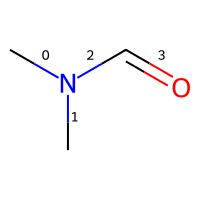

In [5]:
# 결합의 인덱스를 표시
IPythonConsole.drawOptions.addAtomIndices = False  # 원자 인덱스는 표시하지 않음
IPythonConsole.drawOptions.addBondIndices = True  # 결합 인덱스 표시

# 분자 구조 표시 (결합 인덱스 포함)
mol


In [6]:
# 결합(Bond) 특징 벡터 정의
BOND_FEATURES = {
    'bond_type' : [
        'SINGLE',   # 단일 결합
        'DOUBLE',   # 이중 결합
        'TRIPLE',   # 삼중 결합
        'AROMATIC', # 방향족 결합
        'misc'      # 기타 (정의되지 않은 결합 유형)
    ],
    'stereo': [
        'STEREONONE',  # 입체화학적 정보 없음
        'STEREOZ',     # Z(시스)
        'STEREOE',     # E(트랜스)
        'STEREOCIS',   # 시스
        'STEREOTRANS', # 트랜스
        'STEREOANY',   # 임의의 입체화학
    ],
    'conjugated': [False, True],  # 결합이 공명(conjugation)에 참여하는지 여부
}

def get_bond_fv(bond):
    """
    RDKit 결합(Bond) 객체를 특징 벡터로 변환하는 함수
    :param bond: RDKit 결합 객체
    :return: 특징 벡터 (리스트 형태)
    """
    def get_feature_index(feature_list, value):
        """
        주어진 특징 리스트에서 값(value)의 인덱스를 찾고, 리스트에 없으면 'misc' 인덱스 반환
        """
        return feature_list.index(value) if value in feature_list else feature_list.index('misc')

    bond_fv = [
        get_feature_index(BOND_FEATURES['bond_type'], str(bond.GetBondType())),  # 결합 유형 (단일, 이중, 삼중 등)
        get_feature_index(BOND_FEATURES['stereo'], str(bond.GetStereo())),  # 입체화학적 정보
        BOND_FEATURES['conjugated'].index(bond.GetIsConjugated()),  # 공명 여부 (True/False)
    ]
    return bond_fv

# 분자의 각 결합에 대해 특징 벡터 생성
bond_fvs = [get_bond_fv(bond) for bond in mol.GetBonds()]
bond_fvs  # 결합 특징 벡터 출력


[[0, 0, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1]]

### 엣지 인덱스 (Edge Index)

많은 경우, **인접 행렬(Adjacency Matrix)** 대신 **노드 쌍(Paired Node Indices) 목록**을 사용하여 그래프의 엣지를 표현합니다.  
이 방식에서는 엣지를 **(출발 노드, 도착 노드) 쌍**으로 나타내며, 이를 **엣지 인덱스(edge_index)**라고 합니다.

엣지 인덱스는 **(2, num_edges) 형태의 행렬**로 정의되며, 각 열(column)은 두 개의 노드 간 연결을 나타냅니다.

$$
\mathbf{E} = \begin{bmatrix}
    ..., & i, & ..., & j, & ... \\
    ..., & j, & ..., & i, & ...
\end{bmatrix}
$$

즉, 노드 $i$와 노드 $j$ 사이에 **엣지가 존재하면**, 해당 엣지 정보가 위와 같은 형태로 저장됩니다.  
(무향 그래프(Undirected Graph)에서는 $i \to j$뿐만 아니라 $j \to i$도 포함됩니다.)


In [7]:
# 엣지 인덱스 (Edge Index) 초기화
edge_index0, edge_index1 = [], []

# 분자의 결합 정보를 기반으로 엣지 인덱스 생성
for bond in mol.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()  # 결합을 이루는 두 원자의 인덱스 가져오기
    edge_index0 += [i, j]  # 노드 i → j 추가
    edge_index1 += [j, i]  # 무향 그래프이므로 노드 j → i도 추가

# 엣지 인덱스 생성 (PyTorch Geometric 형식)
edge_index = [edge_index0, edge_index1]

# 결과 출력
edge_index


[[0, 1, 1, 2, 1, 3, 3, 4], [1, 0, 2, 1, 3, 1, 4, 3]]

### 분자 그래프 데이터 (Molecular Graph Data)

DMF의 밀도(0.944 $g/cm^3$)를 **그래프 특징(Graph Feature, Label)**로 설정합니다.  
이를 위해 **[PyTorch Geometric의 `Data` 클래스](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)**를 사용하여 DMF의 그래프 데이터를 생성합니다.


In [8]:
import torch
from torch_geometric.data import Data

# 데이터를 PyTorch 텐서로 변환 (모델 학습에 사용)
x = torch.tensor(atom_fvs, dtype=torch.float)  # 원자(노드) 특징 벡터
edge_index = torch.tensor(edge_index, dtype=torch.long)  # 엣지 인덱스
edge_attr = torch.tensor(bond_fvs, dtype=torch.float)  # 결합(엣지) 특징 벡터
y = torch.tensor([0.944], dtype=torch.float)  # DMF의 밀도 (그래프 라벨)

# PyG의 Data 객체를 사용하여 그래프 데이터 생성
dmf_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# 결과 출력
dmf_data


Data(x=[5, 4], edge_index=[2, 8], edge_attr=[4, 3], y=[1])

## 2.2 그래프 뉴럴 네트워크 (Graph Neural Network, GNN)

[그래프 뉴럴 네트워크(GNN)](https://en.wikipedia.org/wiki/Graph_neural_network)는 그래프로 표현된 데이터를 처리하는 인공 신경망(ANN)의 한 종류입니다.  
GNN은 [메시지 패싱(Message Passing)](https://arxiv.org/abs/1704.01212) 방식을 기반으로 동작하며, 이는 **노드들이 이웃 노드들과 정보를 주고받으며 학습하는 과정**을 의미합니다.

일반적으로, GNN은 두 가지 주요 단계를 거칩니다.

1. **메시지 패싱(Message Passing) 단계**  
   - 분자 내에서 노드(원자)들이 연결된 이웃 노드와 정보를 교환  
   - 이러한 정보 교환을 통해 **분자의 뉴럴 표현(Neural Representation)**을 구축  

2. **리드아웃(Readout) 단계**  
   - 최종적으로 학습된 분자의 표현을 사용하여 **특성(Property) 예측** 수행  

즉, GNN은 **분자 그래프의 구조적 정보를 학습하여 용해도, 반응성, 독성 등의 물리·화학적 속성을 예측할 수 있도록 설계됩니다.**


### 메시지 패싱 (Message Passing)

메시지 패싱의 수식을 살펴보기 전에, 먼저 **직관적으로 메시지 패싱이 어떻게 동작하는지** 이해해봅시다.

1. **각 노드는 이웃 노드들에게 보낼 `특징 벡터(feature vector)`를 생성**합니다.  
   - 이 `특징 벡터`는 해당 노드가 이웃에게 보내는 `메시지(message)` 역할을 합니다.

2. **각 노드는 연결된 이웃 노드들로부터 메시지를 받습니다.**  
   - 예를 들어, 아래 그림에서 `노드 1`은 `노드 2`로부터 메시지를 받고,  
     `노드 2`는 `노드 1, 노드 3, 노드 4`로부터 메시지를 받습니다.

<center width="100%" style="padding:10px">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/graph_message_passing.svg" width="700px">
</center>

3. **각 노드는 이웃 노드들로부터 받은 메시지들을 집계(Aggregation)하여 새로운 `메시지 벡터(message vector)`를 생성합니다.**  
   - 즉, 주변 이웃들의 정보를 하나의 벡터로 요약하는 과정입니다.

4. **각 노드는 자신의 `기존 특징 벡터`와 `메시지 벡터`를 조합하여 갱신(Update)합니다.**  
   - 이를 통해 노드는 이웃 노드의 정보를 반영한 새로운 상태로 업데이트됩니다.

---

### **반복적인 메시지 패싱 (Multi-step Message Passing)**

메시지 패싱이 여러 번 반복되면, 노드는 **직접 연결된 이웃뿐만 아니라 더 먼 거리의 노드 정보까지 학습할 수 있습니다.**  
아래 그림에서 `노드 A`는 **두 번의 메시지 패싱(iteration 2)**을 거쳐 **노드 E와 노드 F의 정보까지 반영할 수 있게 됩니다.**

<center width="100%" style="padding:10px">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/messages.svg" width="700px">
</center>

- **Iteration 1**: `노드 C` (노드 A의 이웃)가 `노드 E` 및 `노드 F`로부터 정보를 받음  
- **Iteration 2**: `노드 A`가 `노드 C`를 통해 간접적으로 `노드 E` 및 `노드 F`의 정보를 획득  

즉, **메시지 패싱을 여러 번 수행하면 더 멀리 떨어진 노드의 정보까지 학습할 수 있습니다.** 🚀


**메시지 패싱 과정을 수식으로 이해하기**

메시지 패싱의 개념을 직관적으로 이해한 후, 이를 수학적으로 표현한 공식을 살펴보겠습니다.

---

### **1) 초기화 (Initialization)**

먼저, 각 노드 $i$의 초기 **숨겨진 특징 벡터(hidden feature vector)** $h_i^0$를 해당 노드의 원래 특징 $x_i$에서 가져옵니다.

$$
h_i^0 = I(x_i), \quad \forall i \in V
\tag{1}
$$

여기서,  
- $I$는 **초기화 함수(Initialize Function)**  
- $h_i^0$는 노드 $i$의 초기 **특징 벡터**  
- $x_i$는 노드 $i$의 원래 **노드 특징(Node Feature)**  

---

### **2) 메시지 전송 (Send Message)**

각 노드는 연결된 이웃 노드들에게 메시지를 보냅니다.  
노드 $j$가 노드 $i$로 보내는 메시지 $m_{j \rightarrow i}^{t+1}$는 다음과 같이 정의됩니다.

$$
m_{j \rightarrow i}^{t+1} = M(h_i^t, \: h_j^t, \: e_{i,j})
\tag{2}
$$

여기서,  
- $m_{j \rightarrow i}^{t+1}$: **$t+1$ 번째 메시지 패싱에서 노드 $j$가 노드 $i$로 보내는 메시지**  
- $M$: **메시지 함수(Message Function)**  
- $h_i^t, h_j^t$: **$t$ 번째 메시지 패싱에서의 노드 $i$와 노드 $j$의 특징 벡터**  
- $e_{i,j}$: **노드 $i$와 노드 $j$를 연결하는 엣지의 특징**  

---

### **3) 메시지 집계 (Message Aggregation)**

노드 $i$는 자신과 연결된 모든 이웃 노드들로부터 받은 메시지들을 집계(Aggregation)합니다.

$$
m_i^{t+1} = \sum_{j \in N(i)} m_{j \rightarrow i}^{t+1}
\tag{3}
$$

여기서,  
- $N(i)$: **노드 $i$의 이웃 노드 집합**  
- $m_i^{t+1}$: **$t+1$ 번째 메시지 패싱에서 노드 $i$가 받은 모든 메시지들의 합**  

즉, **노드 $i$는 자신과 연결된 모든 노드로부터 정보를 통합하여 새로운 메시지 벡터를 생성합니다.**

---

### **4) 노드 업데이트 (Node Update)**

최종적으로, 노드 $i$는 자신의 기존 특징 벡터 $h_i^t$와 새로 받은 메시지 벡터 $m_i^{t+1}$을 결합하여 업데이트합니다.

$$
h_i^{t+1} = U(h_i^t, \: m_i^{t+1})
\tag{4}
$$

여기서,  
- $h_i^{t+1}$: **$t+1$ 번째 메시지 패싱 이후의 노드 $i$의 새로운 특징 벡터**  
- $U$: **업데이트 함수(Update Function)**  
- $h_i^t$: **$t$ 번째 메시지 패싱에서의 노드 $i$의 특징 벡터**  
- $m_i^{t+1}$: **$t+1$ 번째 메시지 패싱에서 노드 $i$가 받은 메시지 벡터**  

즉, **각 노드는 이웃 노드들로부터 받은 정보를 바탕으로 자신의 상태를 갱신(Update)하며, 이 과정을 반복하면 전체 그래프의 표현이 학습됩니다.** 🚀


### 리드아웃 (Readout)

리드아웃 레이어(Readout Layer)는 **그래프의 모든 노드들의 숨겨진 특징 벡터(hidden feature vector)를 집계(Aggregation)하여 최종적인 그래프 수준의 벡터(Graph-Level Vector)를 생성**합니다.  
즉, **예측하고자 하는 그래프 전체의 속성(Property)**을 도출하는 과정입니다.

$$
\hat{y} = R(\{ h_i^T \: | \: i \in V\})
\tag{5}
$$

여기서,  
- $h_i^T$ : **메시지 패싱이 끝난 후(T 번째) 노드 $i$의 최종 숨겨진 특징 벡터**  
- $\hat{y}$ : **그래프 전체의 예측값 (Graph-Level Vector, 우리가 예측하려는 목표)**  
- $R$ : **리드아웃 함수(Readout Function), 모든 노드의 정보를 집계하는 역할**  

---

### **GNN의 미분 가능성 (Differentiability in GNNs)**

GNN에서 사용되는 함수들, 즉  
- 초기화 함수 $I$
- 메시지 함수 $M$
- 업데이트 함수 $U$
- 리드아웃 함수 $R$

모두 **미분 가능(Differentiable)** 해야 합니다.  
즉, **다층 인공 신경망(MLP, Multi-Layer Perceptron)과 같은 형태로 학습 가능해야 한다는 점**이 중요합니다.  

이를 통해 GNN 모델은 **역전파(Backpropagation)를 사용하여 그래디언트 기반 최적화가 가능하며**, 분자의 물리·화학적 속성을 학습하고 예측할 수 있습니다. 🚀


### 코드 예제 (Code Example)

여기서는 ["Neural Message Passing for Quantum Chemistry"](https://arxiv.org/abs/1704.01212) 논문에서 제안된 **메시지 패싱 뉴럴 네트워크(MPNN, Message Passing Neural Network)**를 사용하여 GNN 모델을 정의합니다.

PyTorch Geometric의 [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.NNConv.html#torch_geometric.nn.conv.NNConv) 클래스를 활용하여 **메시지 패싱 레이어(Message Passing Layers)**를 생성합니다.

또한, PyG의 [torch_geometric.nn](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) 모듈에는  
다양한 **메시지 패싱 및 리드아웃 레이어**가 포함되어 있어 GNN 모델을 더욱 편리하게 정의할 수 있습니다. 🚀


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import GRU
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, MLP, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

class MPNN(pl.LightningModule):
    def __init__(self, hidden_dim, out_dim,
                 train_data, valid_data, test_data,
                 std, batch_size=32, lr=1e-3):
        """
        메시지 패싱 뉴럴 네트워크(MPNN) 모델 정의
        :param hidden_dim: 숨겨진 차원 크기
        :param out_dim: 출력 차원 크기
        :param train_data: 학습 데이터
        :param valid_data: 검증 데이터
        :param test_data: 테스트 데이터
        :param std: 타겟 데이터의 표준편차(정규화된 데이터 복원을 위해 필요)
        :param batch_size: 미니배치 크기
        :param lr: 학습률 (Learning Rate)
        """
        super().__init__()
        self.std = std
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr

        # 초기 Embedding 레이어 (원자 & 결합)
        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)  # 원자 특징 임베딩
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)  # 결합 특징 임베딩

        # 메시지 패싱 레이어
        nn = MLP([hidden_dim, hidden_dim*2, hidden_dim*hidden_dim])  # NNConv에 사용할 MLP 생성
        self.conv = NNConv(hidden_dim, hidden_dim, nn, aggr='mean')  # NNConv 메시지 패싱 레이어
        self.gru = GRU(hidden_dim, hidden_dim)  # GRU 기반 노드 업데이트 레이어

        # 리드아웃(Readout) 레이어
        self.mlp = MLP([hidden_dim, int(hidden_dim/2), out_dim])  # 그래프 수준 예측을 위한 MLP

    def forward(self, data, mode="train"):
        """
        모델의 순전파 연산 정의
        :param data: PyTorch Geometric Data 객체 (그래프 데이터)
        :param mode: 현재 실행 모드 (학습, 검증, 테스트 구분)
        :return: 그래프 수준 예측값
        """

        # 초기화 단계: 원자 및 결합 임베딩
        x = self.atom_emb(data.x)  # 원자 임베딩 적용
        h = x.unsqueeze(0)  # GRU 입력을 위해 차원 변경
        edge_attr = self.bond_emb(data.edge_attr)  # 결합 임베딩 적용

        # 메시지 패싱 단계 (3번 반복)
        for i in range(3):
            m = F.relu(self.conv(x, data.edge_index, edge_attr))  # 메시지 전달 및 집계
            x, h = self.gru(m.unsqueeze(0), h)  # 노드 업데이트
            x = x.squeeze(0)  # 차원 복원

        # 리드아웃(Readout) 단계
        x = global_add_pool(x, data.batch)  # 그래프 수준의 벡터 생성
        x = self.mlp(x)  # 최종 예측값 출력

        return x.view(-1)  # 벡터 형태 변환 후 반환

    def training_step(self, batch, batch_idx):
        """
        학습 단계 정의 (손실 계산 및 로깅)
        :param batch: 배치 데이터
        :param batch_idx: 배치 인덱스
        """
        out = self.forward(batch, mode="train")  # 순전파 실행
        loss = F.mse_loss(out, batch.y)  # 평균 제곱 오차(MSE) 손실 계산
        self.log("Train loss", loss)  # 학습 손실 로깅
        return loss

    def validation_step(self, batch, batch_idx):
        """
        검증 단계 정의 (MSE 손실 계산 및 로깅)
        :param batch: 배치 데이터
        :param batch_idx: 배치 인덱스
        """
        out = self.forward(batch, mode="valid")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # 표준편차를 적용하여 원래 단위로 변환 후 MSE 계산
        self.log("Valid MSE", loss)  # 검증 손실 로깅

    def test_step(self, batch, batch_idx):
        """
        테스트 단계 정의 (MSE 손실 계산 및 로깅)
        :param batch: 배치 데이터
        :param batch_idx: 배치 인덱스
        """
        out = self.forward(batch, mode="test")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # 표준편차를 적용하여 원래 단위로 변환 후 MSE 계산
        self.log("Test MSE", loss)  # 테스트 손실 로깅

    def configure_optimizers(self):
        """
        옵티마이저 설정 (Adam 사용)
        :return: Adam 옵티마이저 객체
        """
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr  # 학습률 설정
        )
        return optimizer

    def train_dataloader(self):
        """
        학습 데이터 로더 반환
        """
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        """
        검증 데이터 로더 반환
        """
        return DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        """
        테스트 데이터 로더 반환
        """
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)


여기서는 PyG의 [`InMemoryDataset`](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html) 클래스를 사용하여 **ESOL 데이터셋을 그래프 데이터셋으로 변환**할 수 있습니다.  
이를 통해 **그래프 데이터셋을 더욱 편리하게 생성하고 관리**할 수 있습니다.

추가적으로, PyG에서 제공하는 [튜토리얼](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html)과 [사전 정의된 데이터셋 목록](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)을 참고하면,  
PyG를 활용하여 **그래프 데이터셋을 보다 쉽게 생성하고 활용하는 방법**을 배울 수 있습니다.


In [10]:
from tqdm import tqdm
import pandas as pd
import torch
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
)
from ogb.utils import smiles2graph

class ESOLGraphData(InMemoryDataset):
    """
    PyG의 InMemoryDataset을 사용하여 ESOL 그래프 데이터셋을 생성하는 클래스
    """
    # ESOL 데이터셋 다운로드 링크
    raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'

    def __init__(self, root, transform=None):
        """
        :param root: 데이터셋이 저장될 기본 디렉토리
        :param transform: 데이터 변환 함수 (선택적)
        """
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])  # 사전 처리된 데이터 로드

    @property
    def raw_file_names(self):
        """
        원본 데이터 파일 이름을 반환하는 프로퍼티
        - @property 데코레이터를 사용하여 메서드를 속성처럼 접근할 수 있도록 함
        """
        return ['delaney-processed.csv']

    @property
    def processed_file_names(self):
        """
        사전 처리된 데이터 파일 이름을 반환하는 프로퍼티
        """
        return ['data.pt']

    def download(self):
        """
        ESOL 데이터셋을 다운로드하는 메서드
        """
        print('Downloading ESOL dataset...')
        file_path = download_url(self.raw_url, self.raw_dir)  # 지정된 URL에서 데이터 다운로드

    def process(self):
        """
        원본 CSV 데이터를 로드하고, PyG의 그래프 데이터로 변환하여 저장하는 메서드
        """
        # CSV 파일에서 원본 데이터 로드
        df = pd.read_csv(self.raw_paths[0])
        smiles = df['smiles'].values.tolist()  # SMILES 문자열 목록
        target = df['measured log solubility in mols per litre'].values.tolist()  # 용해도 값

        # SMILES를 그래프 데이터로 변환
        print('Converting SMILES strings into graphs...')
        data_list = []
        for i, smi in enumerate(tqdm(smiles)):  # 진행률 바를 포함하여 변환 진행

            # SMILES에서 그래프 데이터 생성
            graph = smiles2graph(smi)

            # 그래프 데이터를 PyTorch 텐서로 변환
            x = torch.tensor(graph['node_feat'], dtype=torch.long)  # 노드 특징
            edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # 엣지 인덱스
            edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)  # 엣지 특징
            y = torch.tensor([target[i]], dtype=torch.float)  # 용해도 값

            # PyG의 Data 객체로 변환
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data_list.append(data)

        # 데이터 저장
        torch.save(self.collate(data_list), self.processed_paths[0])


📌 `@property`란?  
`@property`는 Python의 데코레이터(Decorator)로, 메서드를 속성(Attribute)처럼 사용할 수 있도록 해주는 기능입니다.  
즉, 함수처럼 호출하지 않고, 속성처럼 접근할 수 있습니다.

```python
class Example:
    def __init__(self):
        self._value = 42  # 내부 변수 (비공개 변수)

    @property
    def value(self):
        """값을 반환하는 프로퍼티 메서드"""
        return self._value  # self.value 로 접근 가능

example = Example()
print(example.value)  # 함수 호출 없이 속성처럼 접근 가능
# 출력: 42
```
📌 코드에서 `@property` 활용 예

- **`raw_file_names`**  
  - 원본 데이터셋 파일 이름을 리스트로 반환  
  - `dataset.raw_file_names`처럼 속성처럼 접근 가능 (`dataset.raw_file_names()`가 아님)  

- **`processed_file_names`**  
  - 변환된 데이터셋 파일 이름을 리스트로 반환  
  - `dataset.processed_file_names`처럼 속성처럼 접근 가능  

👉 `@property`를 사용하면 **클래스 내부의 데이터에 간결하고 직관적으로 접근할 수 있습니다!**  


ESOL 그래프 데이터셋을 생성하고, 정규화한 후 훈련/검증/테스트 세트로 분할합니다.


In [ ]:
from deepchem.splits import RandomSplitter

# ESOL 그래프 데이터셋 생성 및 셔플링
dataset = ESOLGraphData('./esol_pyg').shuffle()

# 타겟 값 정규화 (평균 = 0, 표준편차 = 1로 변환)
mean = dataset.data.y.mean()  # 평균 계산
std = dataset.data.y.std()  # 표준편차 계산
dataset.data.y = (dataset.data.y - mean) / std  # 정규화 적용
mean, std = mean.item(), std.item()  # PyTorch 텐서를 스칼라 값으로 변환

# 데이터셋 분할 (훈련 70%, 검증 10%, 테스트 20%)
splitter = RandomSplitter()
train_idx, valid_idx, test_idx = splitter.split(dataset, frac_train=0.7, frac_valid=0.1, frac_test=0.2)

# 각 데이터셋 생성
train_dataset = dataset[train_idx]
valid_dataset = dataset[valid_idx]
test_dataset = dataset[test_idx]


모델을 학습시키고 평가합니다.


In [ ]:
# GNN 모델 인스턴스 생성 (하이퍼파라미터 조정 가능)
gnn_model = MPNN(
    hidden_dim=128,  # 숨겨진 차원 크기
    out_dim=1,  # 출력 차원 (용해도 예측)
    std=std,  # 정규화된 타겟 값을 복원하기 위한 표준편차
    train_data=train_dataset,  # 훈련 데이터셋
    valid_data=valid_dataset,  # 검증 데이터셋
    test_data=test_dataset,  # 테스트 데이터셋
    lr=1e-3,  # 학습률
    batch_size=32  # 배치 크기
)

# PyTorch Lightning Trainer 정의
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",  # GPU 사용 설정
    devices=1  # 사용할 GPU 개수 (1개)
)


# 모델 학습 수행
trainer.fit(model=gnn_model)

# 테스트 실행
results = trainer.test(ckpt_path="best")

# 테스트 RMSE 계산
test_mse = results[0]["Test MSE"]
test_rmse = test_mse ** 0.5
print(f"\nMPNN 모델 성능: 테스트 세트 RMSE = {test_rmse:.4f}\n")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | atom_emb | AtomEncoder | 22.3 K | train
1 | bond_emb | BondEncoder | 1.7 K  | train
2 | conv     | NNConv      | 4.3 M  | train
3 | gru      | GRU         | 99.1 K | train
4 | mlp      | MLP         | 8.4 K  | train
-------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.569    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 424. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 412. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 462. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 230. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

훈련한 모델을 가지고 임의의 분자의 용해도를 예측해봅시다.

In [ ]:
import numpy as np
import torch
from deepchem.feat import RDKitDescriptors
from rdkit import Chem
from rdkit.Chem import Descriptors

def smiles_to_graph(smiles):
    """
    SMILES 문자열을 PyG의 그래프 데이터 형식으로 변환하는 함수
    :param smiles: 변환할 SMILES 문자열
    :return: PyG Data 객체
    """
    from ogb.utils import smiles2graph
    graph = smiles2graph(smiles)

    x = torch.tensor(graph['node_feat'], dtype=torch.long)  # 노드 특징
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # 엣지 인덱스
    edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)  # 엣지 특징

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)  # PyG Data 객체 생성
    return data

def predict_solubility(model, smiles, std):
    """
    학습된 GNN 모델을 사용하여 SMILES의 용해도를 예측하는 함수
    :param model: 학습된 GNN 모델
    :param smiles: 용해도를 예측할 SMILES 문자열
    :param std: 데이터 정규화를 되돌리기 위한 표준편차
    :return: 예측된 용해도 값 (log mol/L 및 mol/L)
    """
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 그래디언트 계산 비활성화
        graph_data = smiles_to_graph(smiles)  # SMILES를 그래프 데이터로 변환
        graph_data.batch = torch.zeros(graph_data.x.shape[0], dtype=torch.long)  # 배치 처리용 추가

        prediction = model(graph_data).item()  # 모델을 통해 예측 수행
        log_solubility = prediction * std  # 정규화된 값을 원래 값으로 변환
        solubility_mol_L = 10 ** log_solubility  # log(mol/L) → mol/L 변환
    return log_solubility, solubility_mol_L

def calculate_molecular_weight(smiles):
    """
    주어진 SMILES 문자열의 1 mol당 g(분자량, Molecular Weight)를 계산하는 함수
    :param smiles: 분자 구조를 나타내는 SMILES 문자열
    :return: 분자량 (g/mol)
    """
    mol = Chem.MolFromSmiles(smiles)  # SMILES 문자열을 RDKit 분자 객체로 변환
    if mol is None:
        raise ValueError("유효하지 않은 SMILES 문자열입니다.")
    return Descriptors.MolWt(mol)  # RDKit을 사용하여 분자량 계산

# 예측 실행
trained_model = gnn_model  # 학습된 GNN 모델 사용
test_smiles = "O=C(C)Oc1ccccc1C(=O)O"  # 예측할 SMILES (예: 아스피린)
predicted_log_solubility, predicted_solubility_mol_L = predict_solubility(trained_model, test_smiles, std)

print(f"SMILES: {test_smiles}")
print(f"Predicted log Solubility: {predicted_log_solubility:.4f} log(mol/L)")
print(f"Predicted Solubility: {predicted_solubility_mol_L:.6f} mol/L")
print(f"Predicted Solubility: {predicted_solubility_mol_L * calculate_molecular_weight(test_smiles):.6f} g/L")

# 아스피린의 용해도는 3 g/L 입니다.
